In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time

import sys
sys.path.insert(0, '../')

In [2]:
from libra import ObservationArchive, mask_simultaneous_transits, transit_model, trappist1

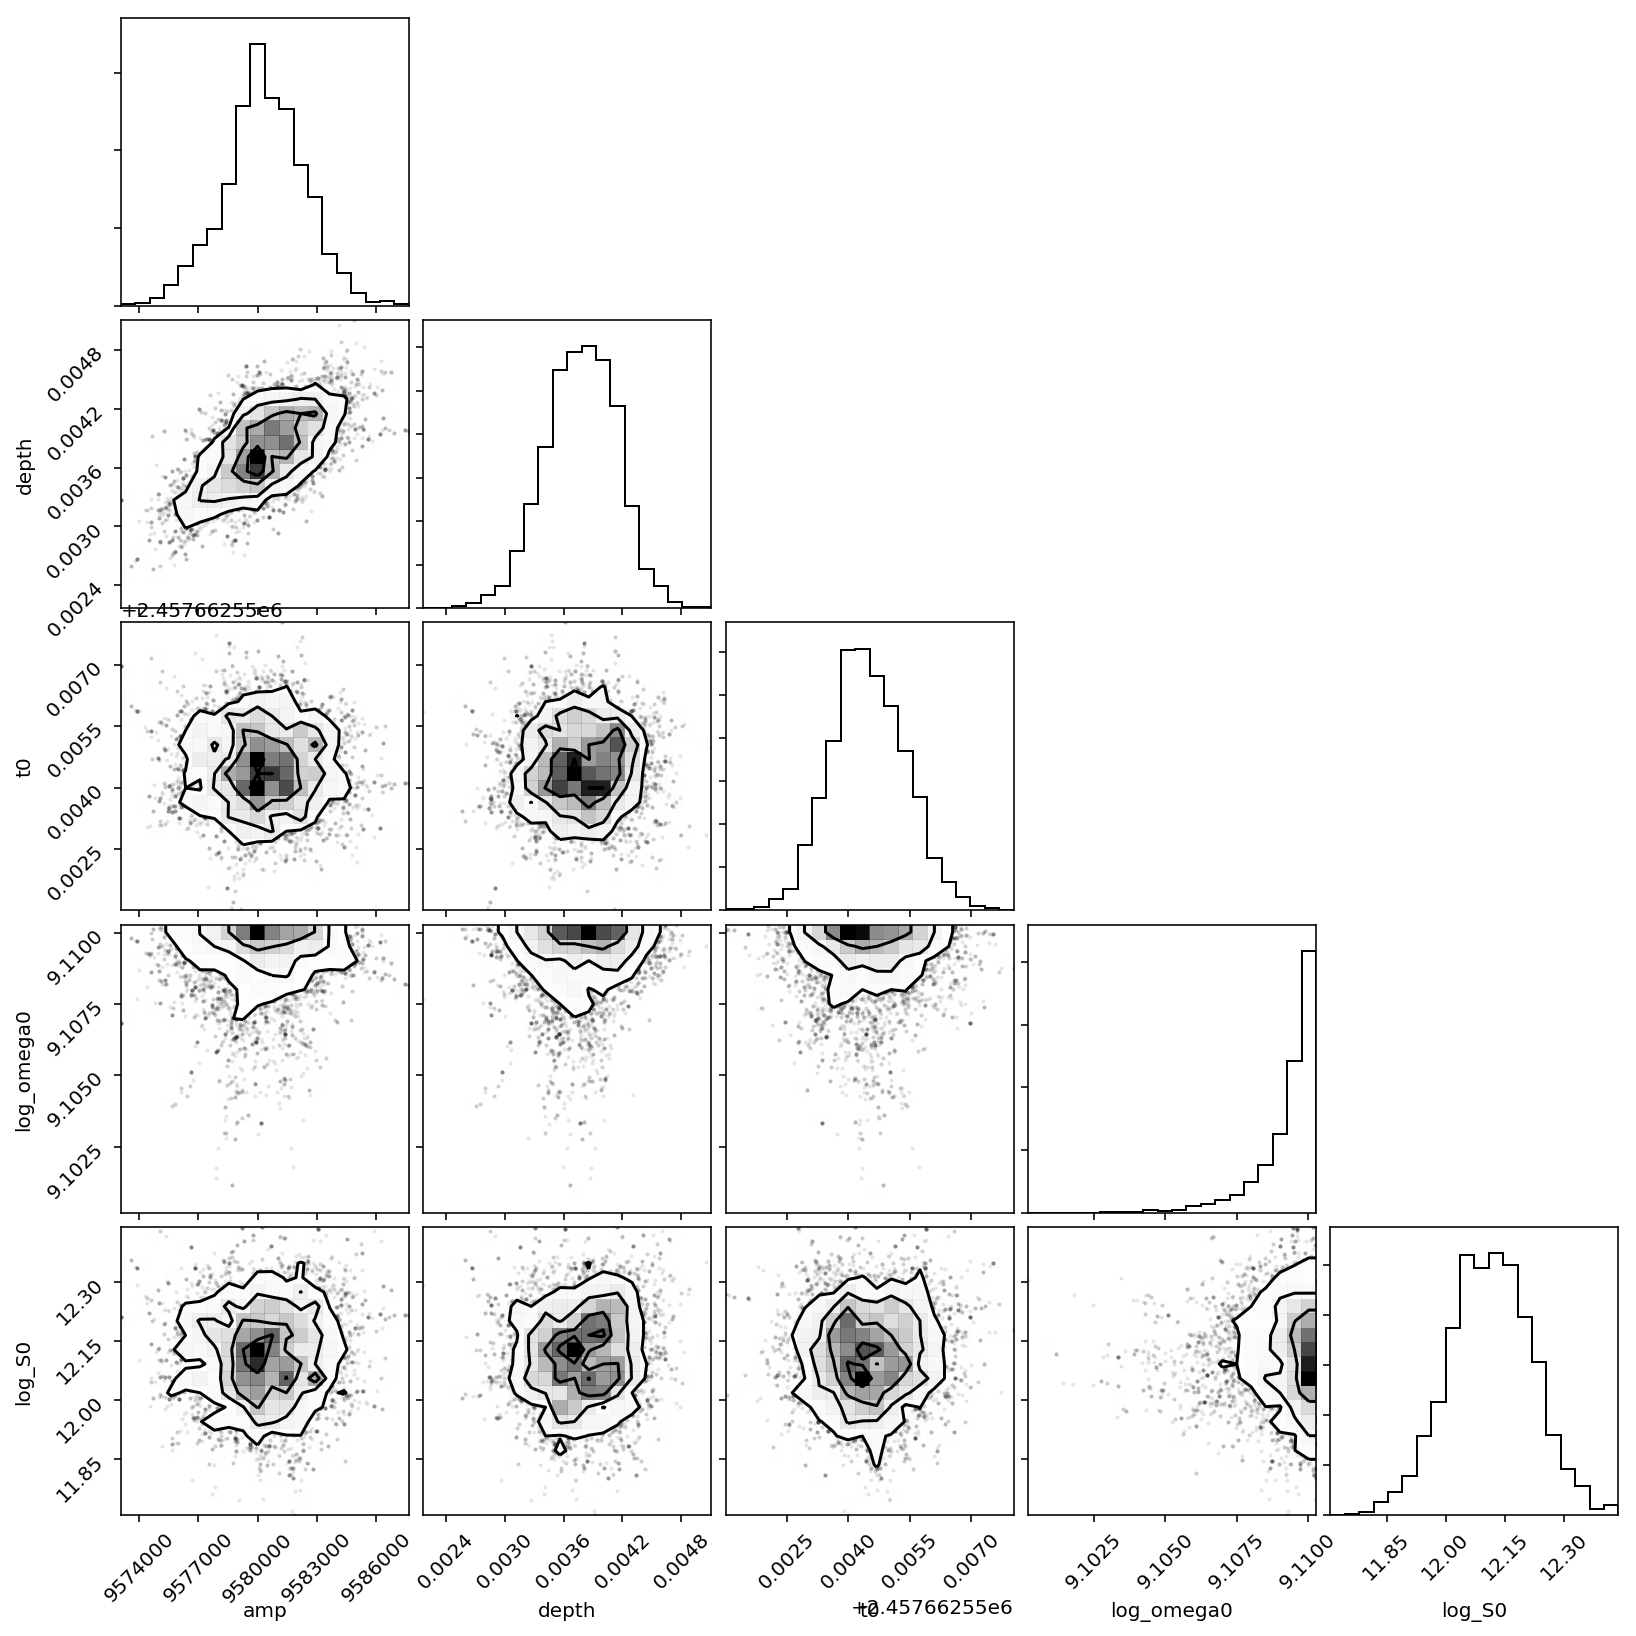

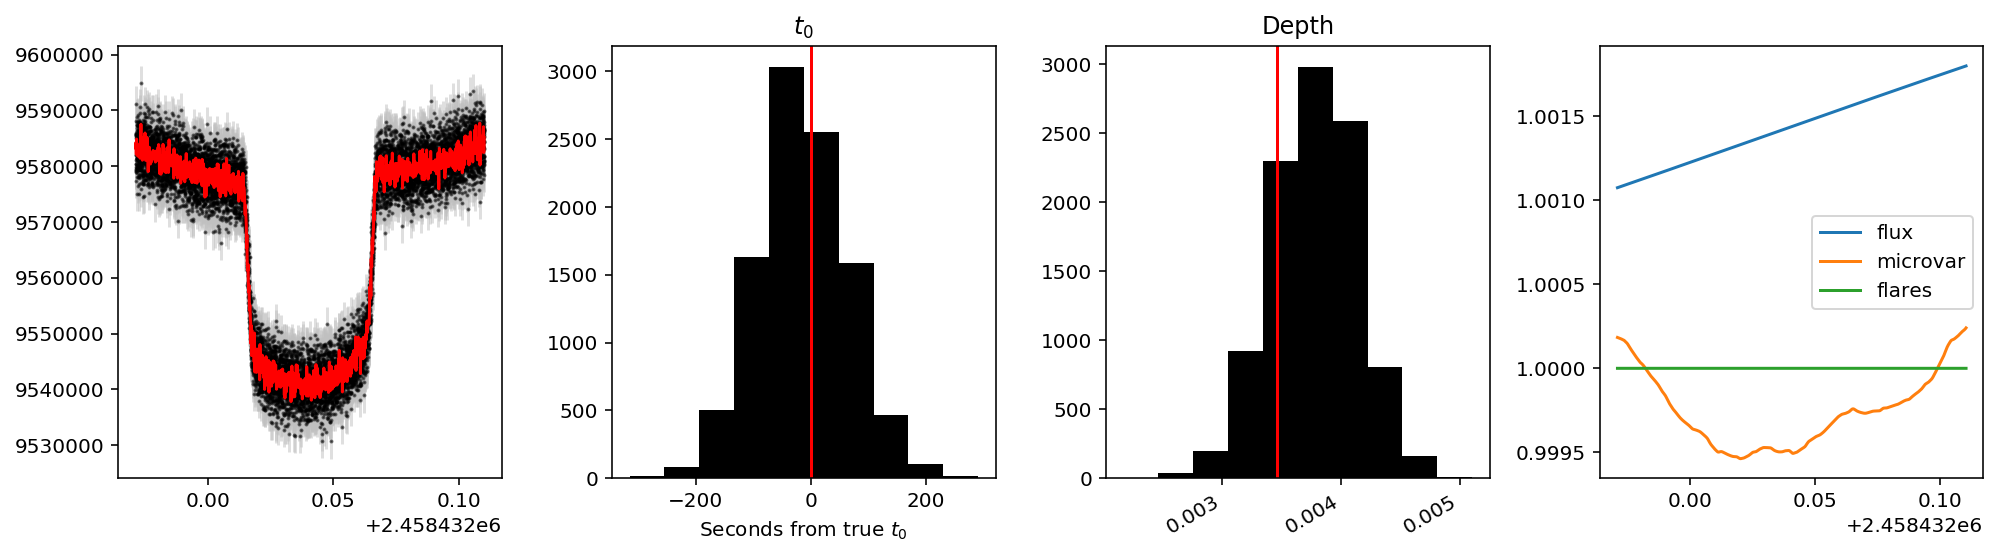

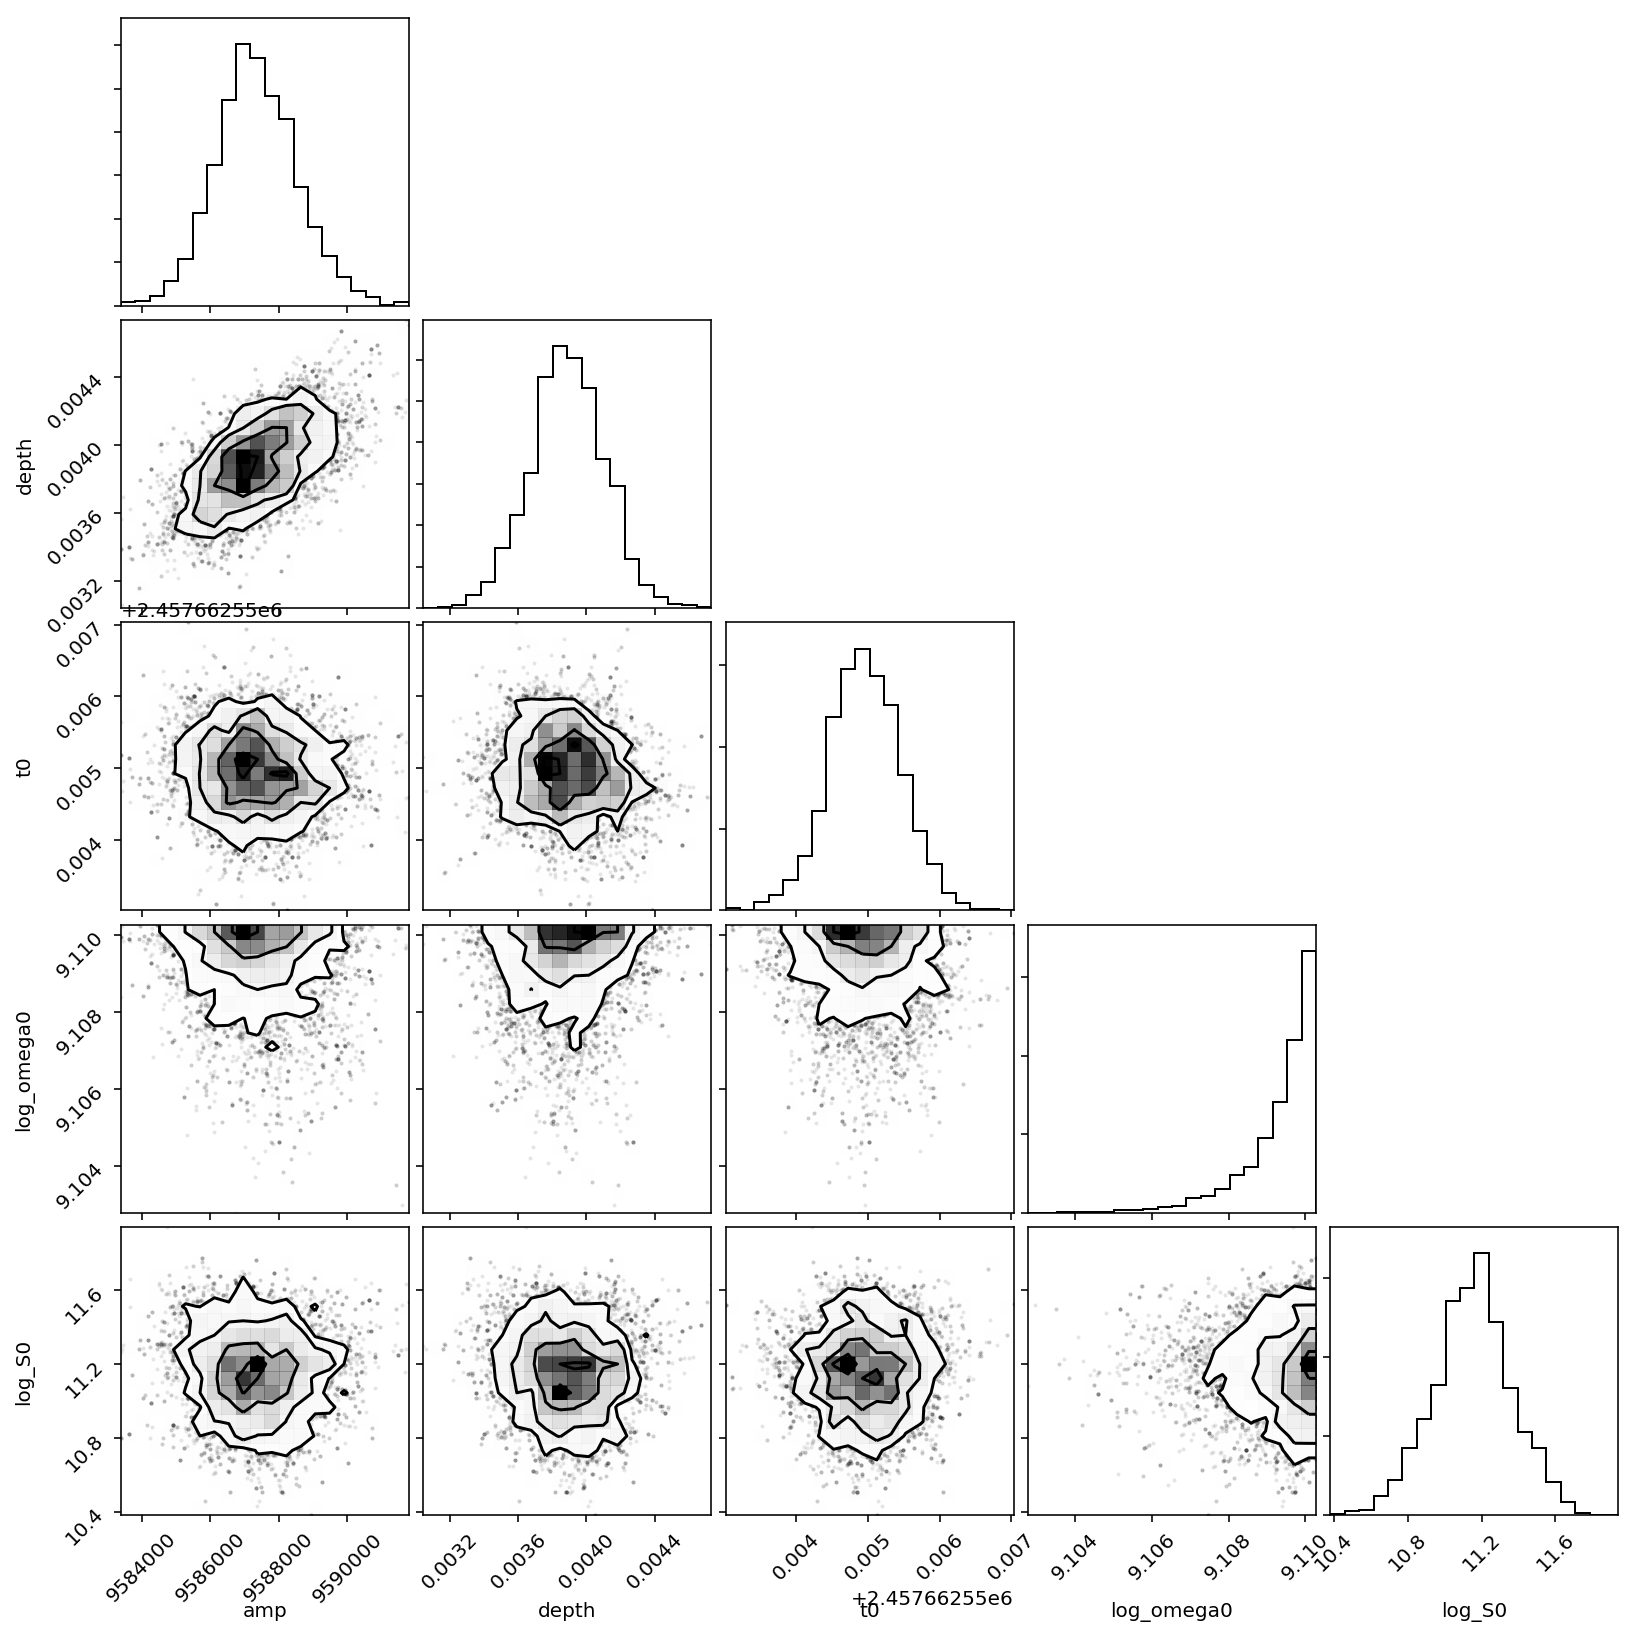

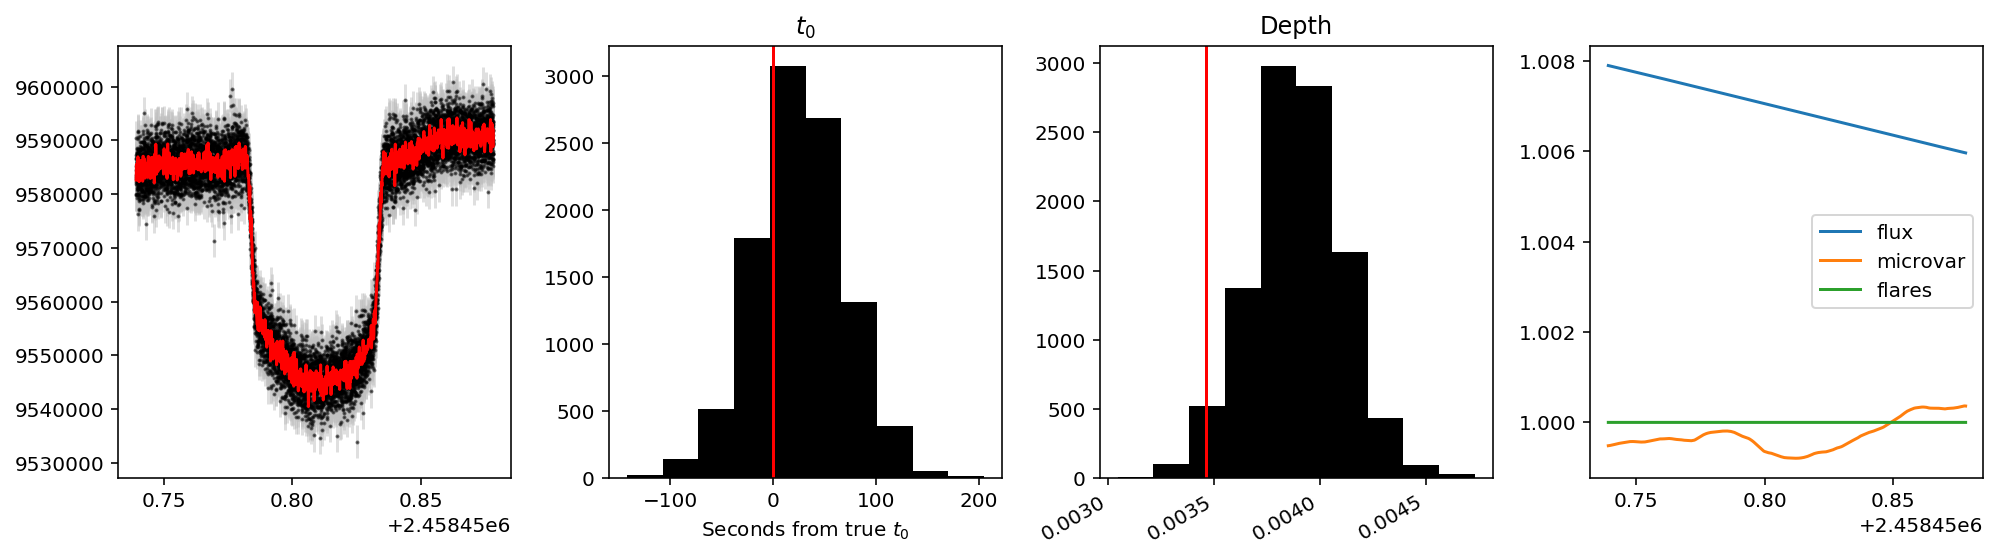

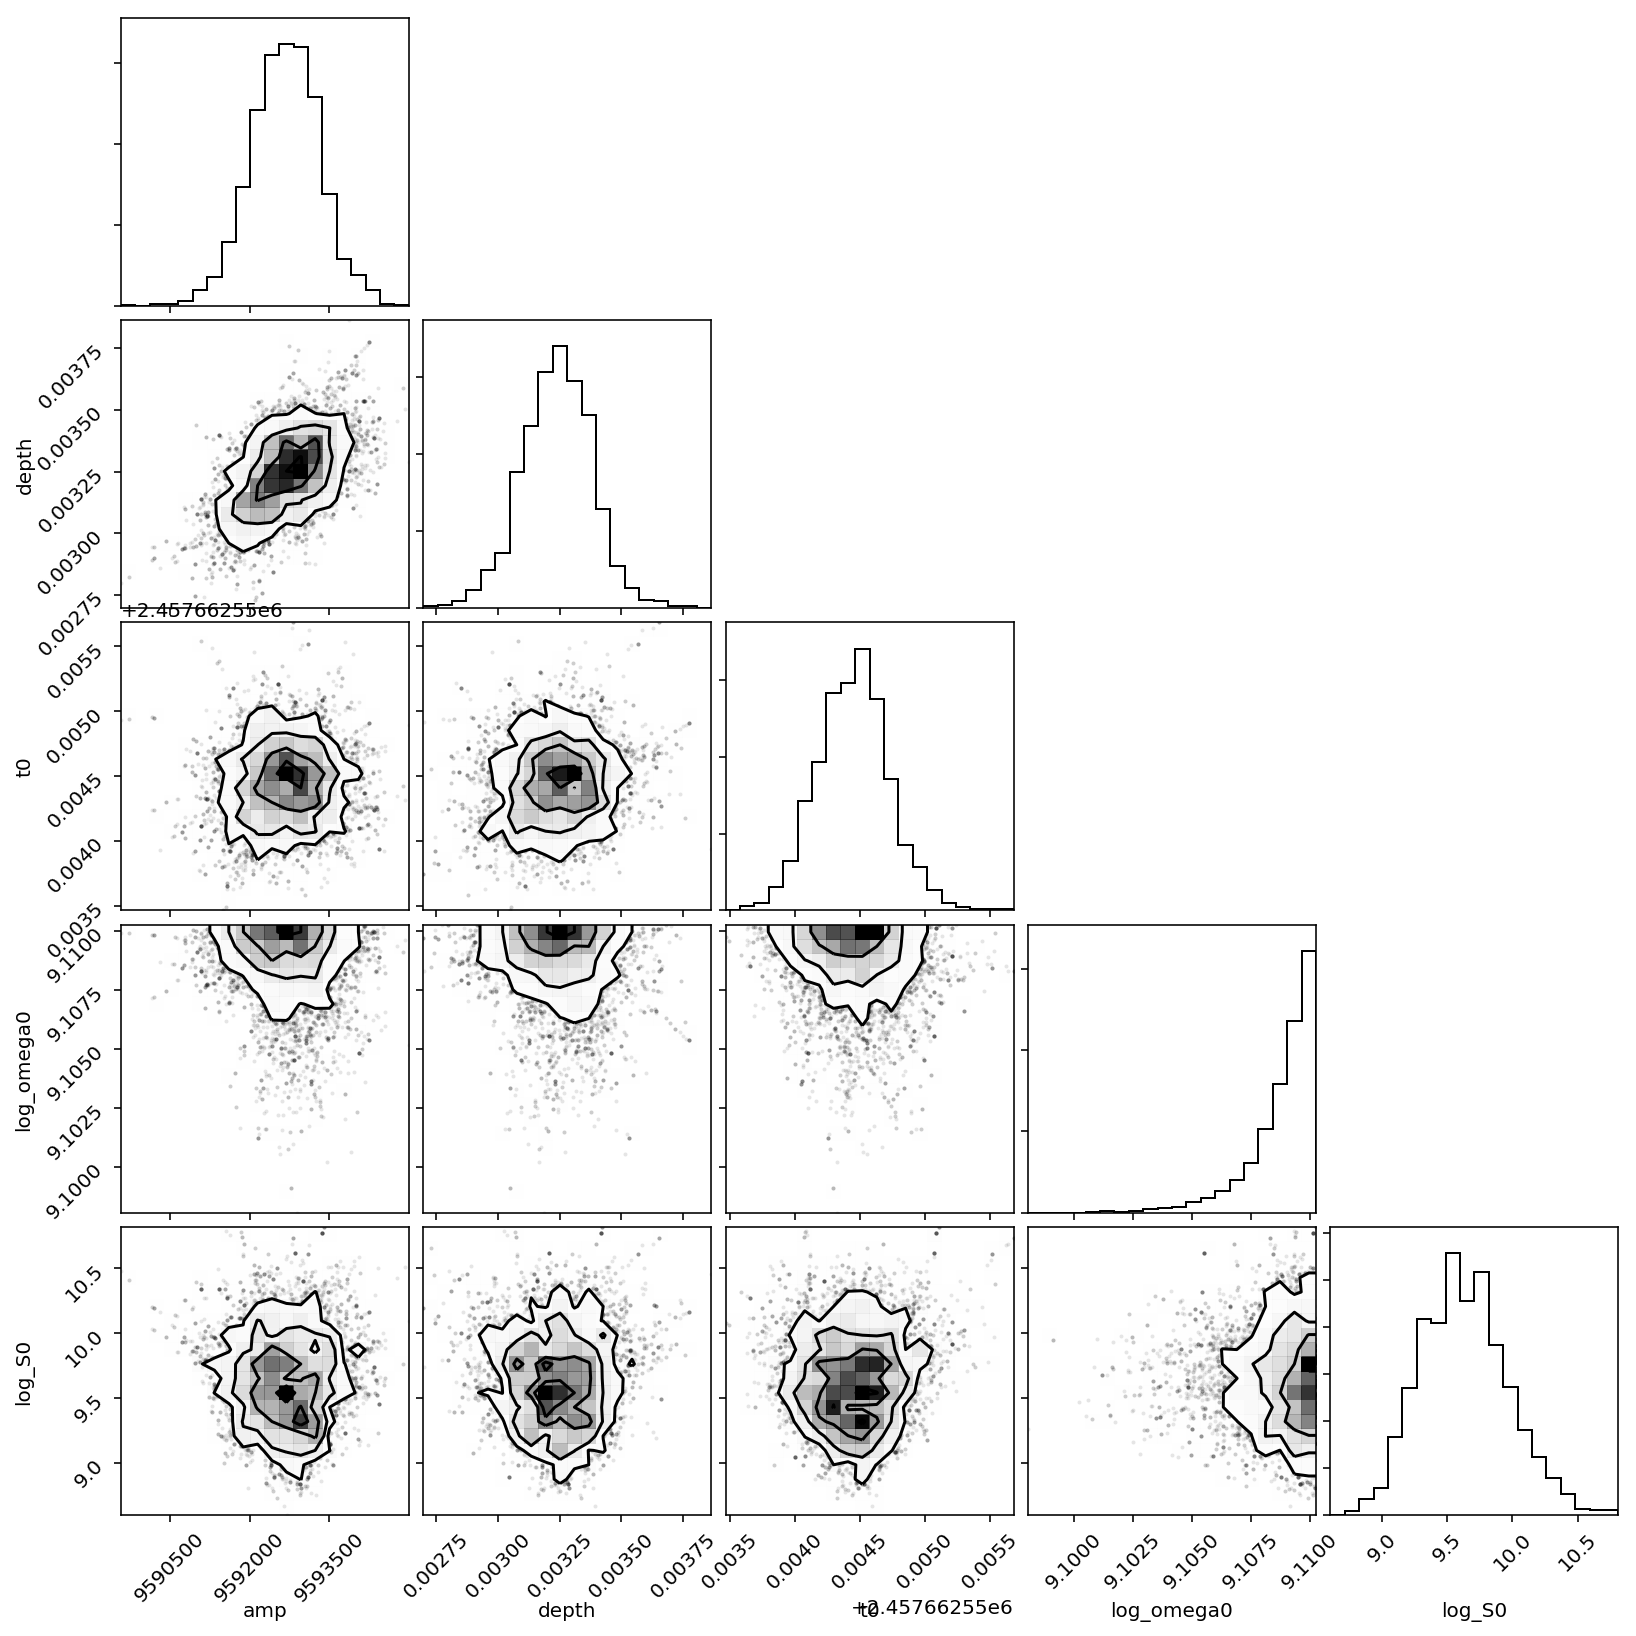

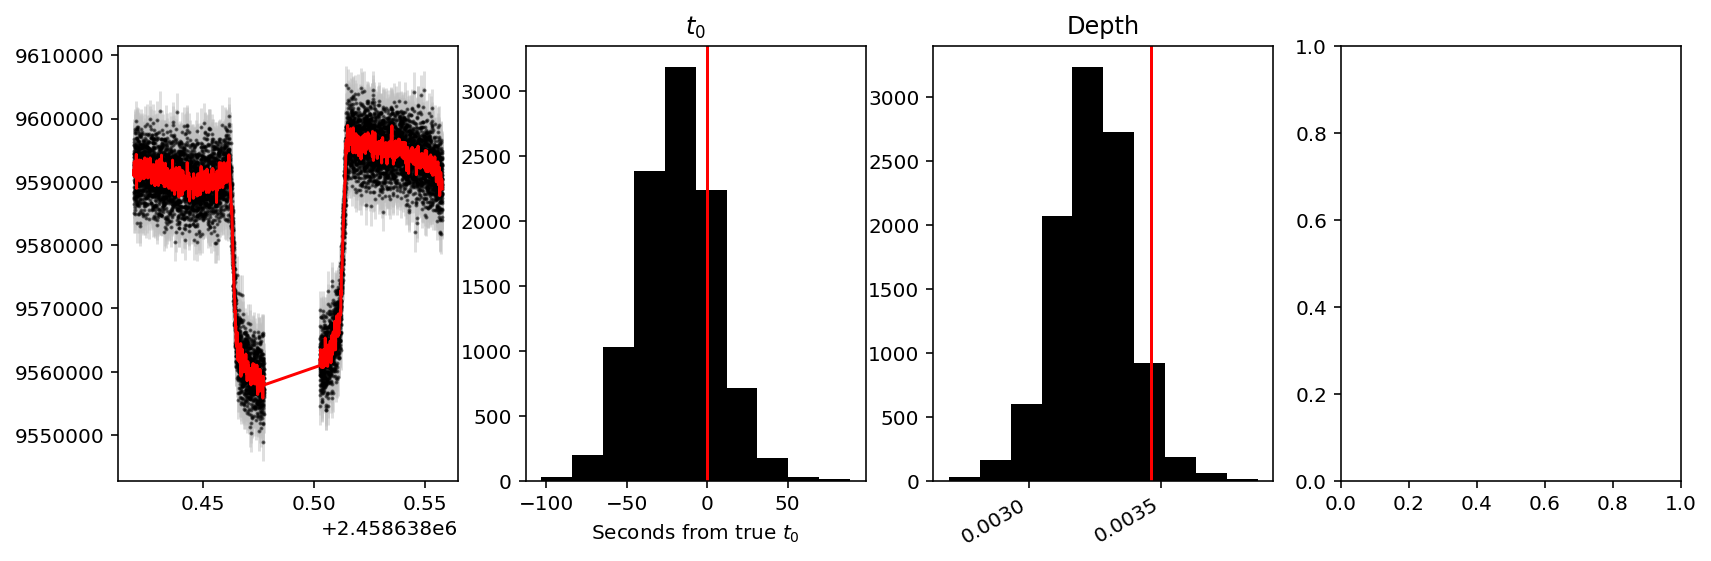

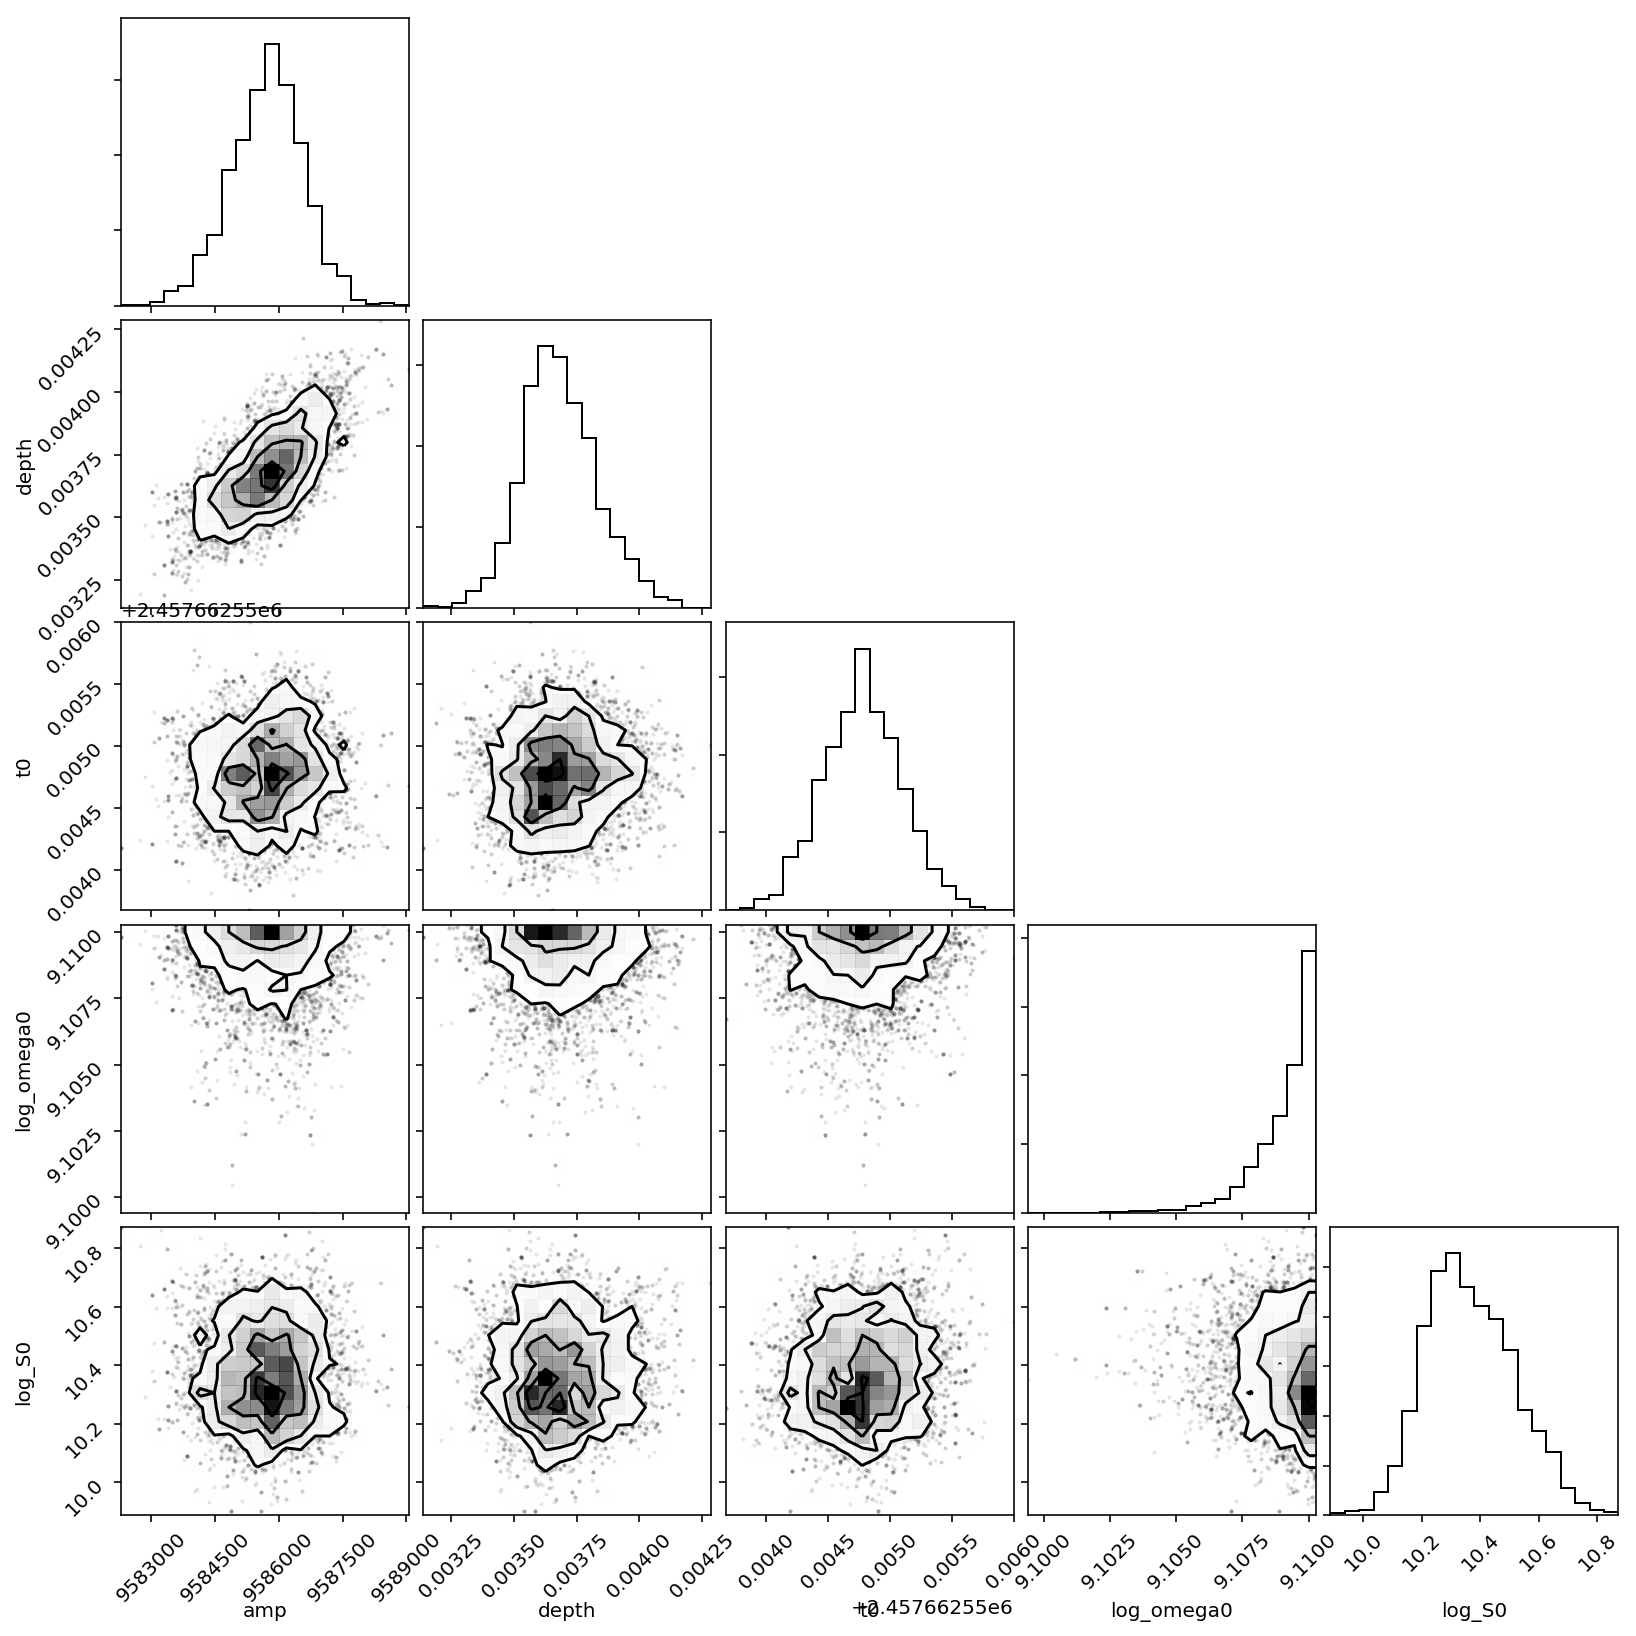

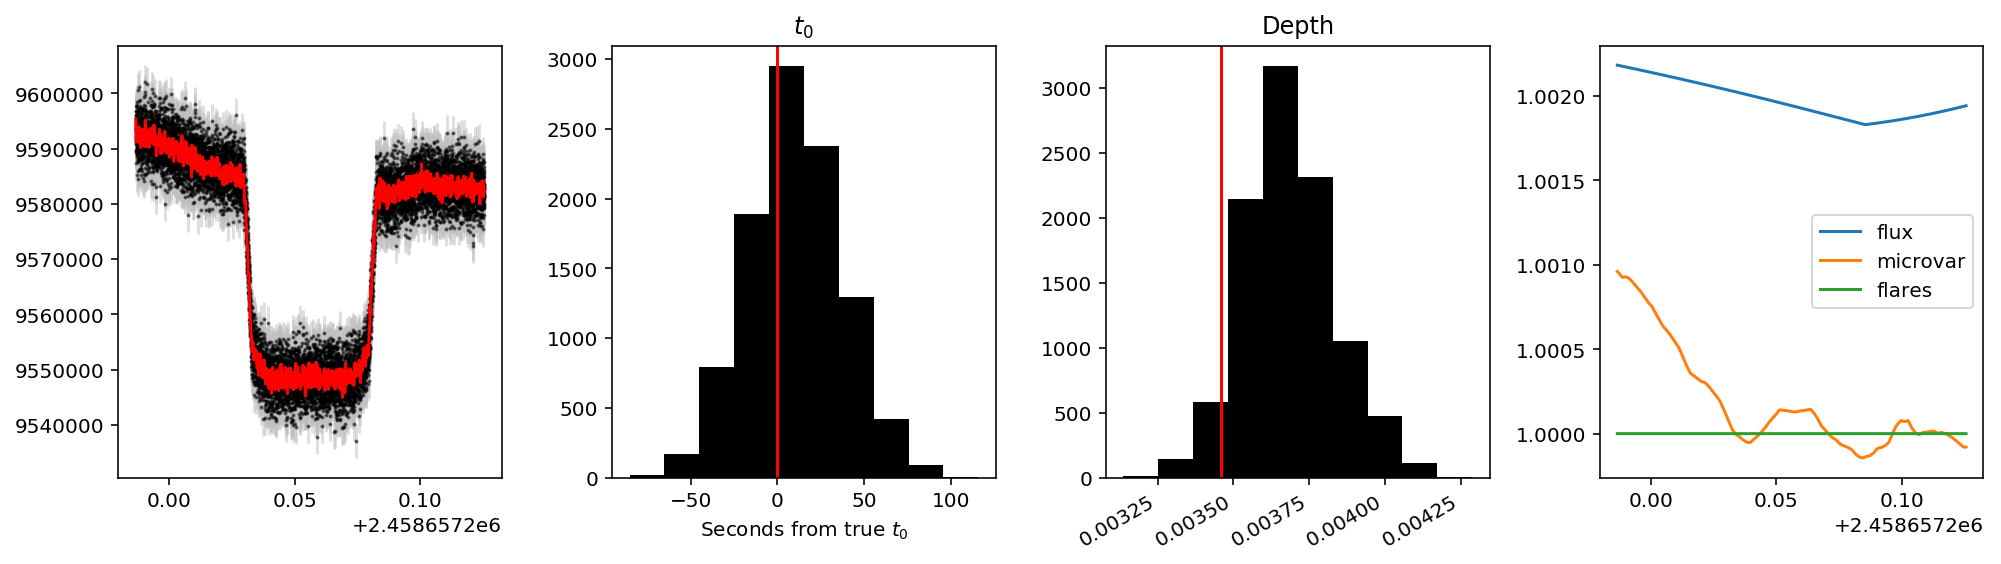

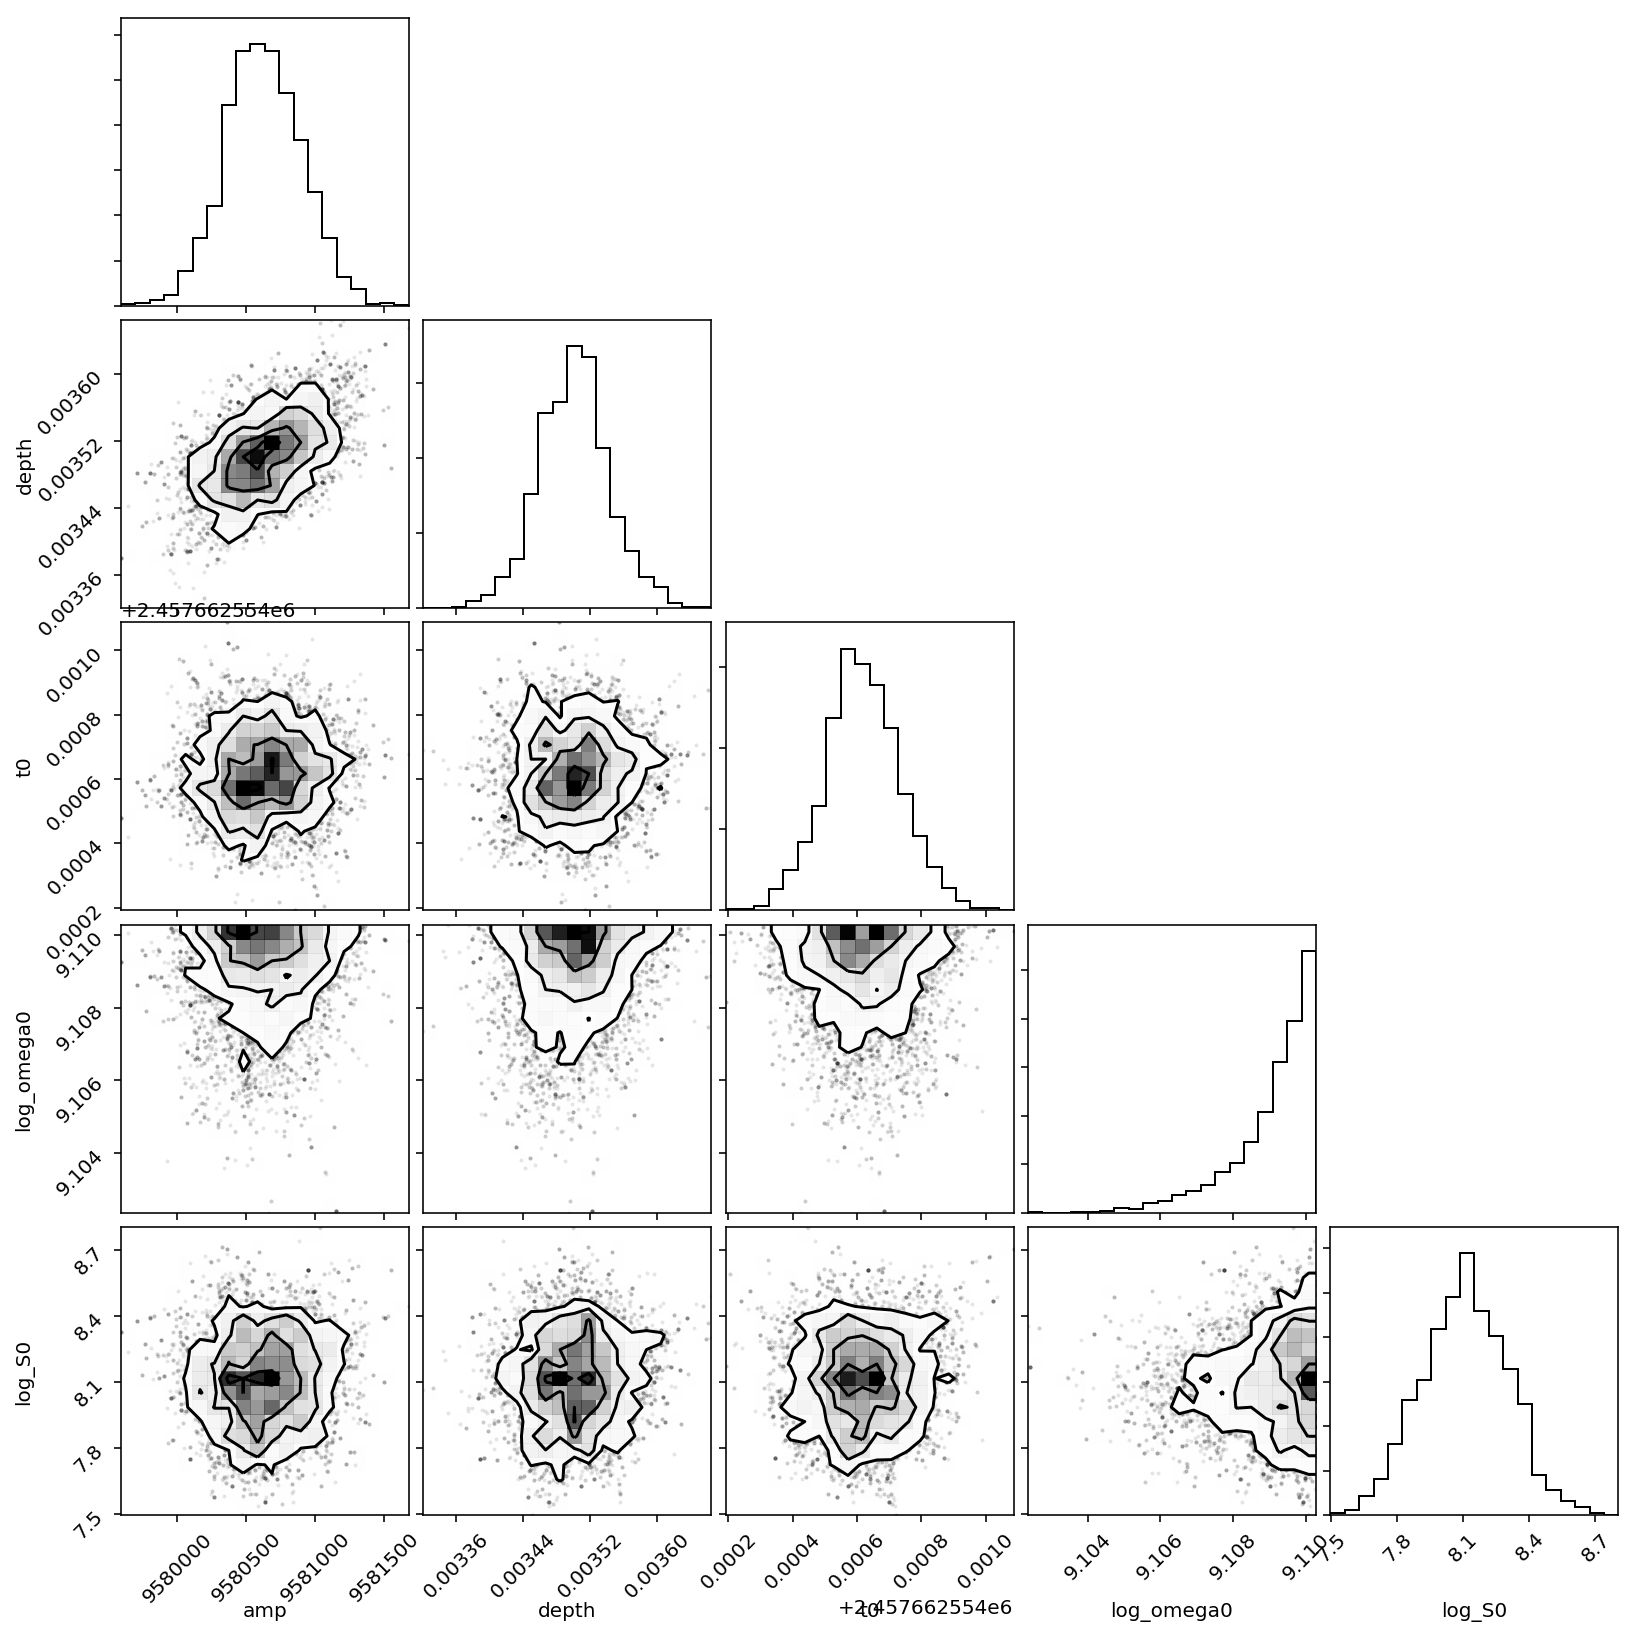

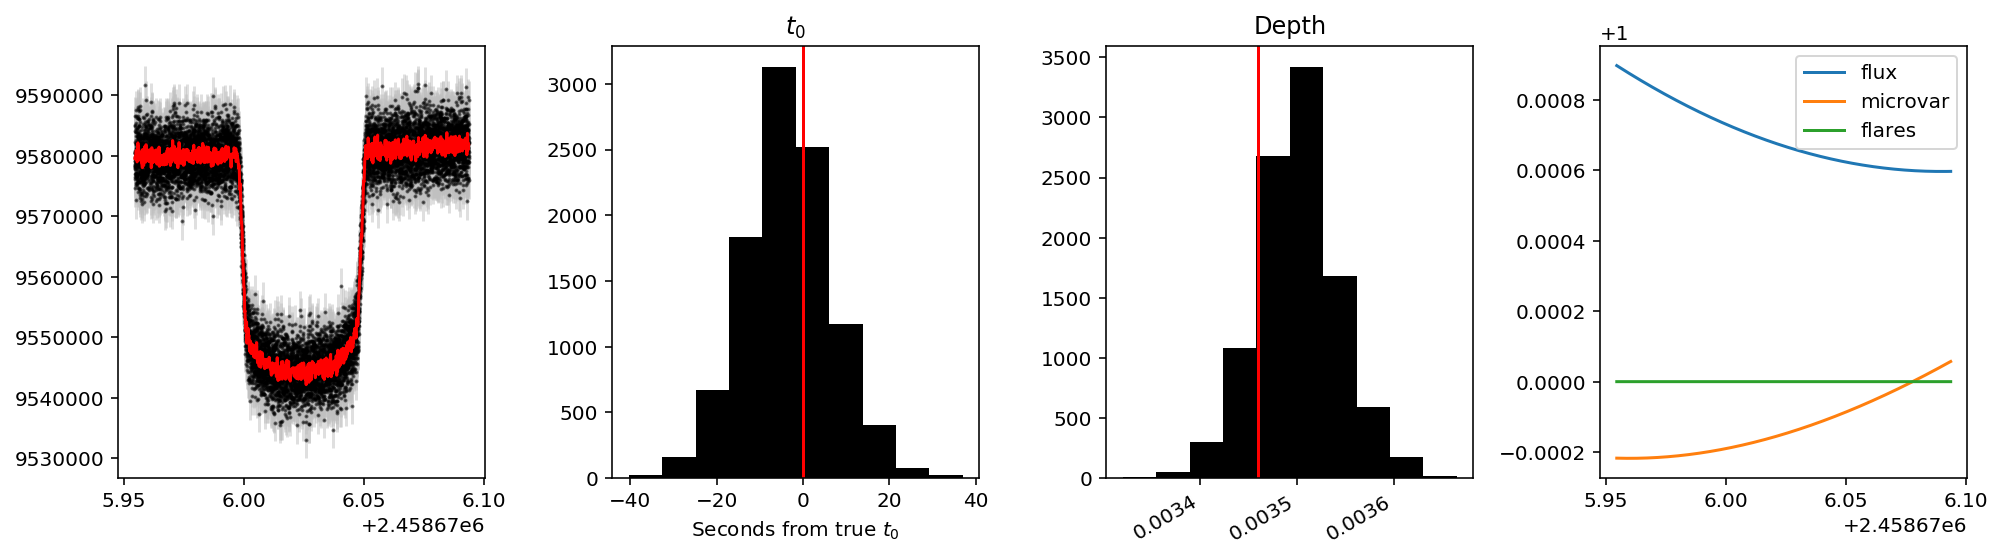

In [10]:
import celerite
from celerite import terms
from celerite.modeling import Model
from copy import deepcopy


run_name = 'trappist1_bright'
planet = 'h'

original_params = trappist1(planet)

class MeanModel(Model):
    parameter_names = ['amp', 'depth', 't0']

    def get_value(self, t):
        params = deepcopy(original_params)
        params.rp = self.depth**0.5
        params.t0 = self.t0
        times = t - t.mean()
        return self.amp * transit_model(t, params)


with ObservationArchive(run_name, 'a') as obs:
    for obs_planet in getattr(obs, planet):
        mask = mask_simultaneous_transits(obs_planet.times, planet)
        obs_time = obs_planet.times[mask]
        obs_flux = np.sum(obs_planet.spectra[mask], axis=1)
        obs_err = np.sqrt(obs_flux)
        
        # GP
        initp_dict = dict(amp=np.median(obs_flux), depth=original_params.rp**2, 
                          t0=original_params.t0)#, c0=0, c1=0)

        parameter_bounds = dict(amp=[np.min(obs_flux), np.max(obs_flux)], 
                                depth=[0.5 * original_params.rp**2, 1.5 * original_params.rp**2],
                                t0=[original_params.t0 - 0.5, original_params.t0 + 0.5])

        mean_model = MeanModel(**initp_dict, bounds=parameter_bounds)
        Q = 1.0 / np.sqrt(2.0)
        w0 = 3.0
        S0 = 10
        bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
        kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                                bounds=bounds)
        kernel.freeze_parameter("log_Q") 
        
        gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
        gp.compute(obs_time, obs_err)
        
        try: 
            bestp = obs_planet.samples_median

            gp.set_parameter_vector(bestp)

            skip = 10
            mu, var = gp.predict(obs_flux, obs_time[::skip], return_var=True)
            std = np.sqrt(var)

            samples = np.vstack([obs_planet.samples_amp, obs_planet.samples_depth, obs_planet.samples_t0, obs_planet.samples_log_omega0, obs_planet.samples_log_S0])
            from corner import corner
            corner(samples.T, labels=['amp', 'depth', 't0', 'log_omega0', 'log_S0'])
            plt.show()
            
            fig, ax = plt.subplots(1, 4, figsize=(14, 4))
            ax[0].errorbar(obs_time, obs_flux, obs_err, fmt='.', color='k', ecolor='silver', ms=2, alpha=0.5)
            ax[0].plot(obs_time[::skip], mu, 'r', zorder=10)

            answer_key = dict(obs_planet.attrs)
            mid_transit_answer = answer_key['t0']
            n_transits = np.round((obs_planet.samples_t0.mean() - mid_transit_answer) / trappist1(planet).per)
            mid_transit_answer_translated = mid_transit_answer + trappist1(planet).per * n_transits

            ax[1].hist((obs_planet.samples_t0 - mid_transit_answer_translated)*24*60*60, color='k')
            ax[1].axvline(mid_transit_answer_translated - mid_transit_answer_translated, color='r')
            ax[1].set_title('$t_0$')
            ax[1].set_xlabel('Seconds from true $t_0$')
            
            ax[2].set_title('Depth')
            ax[2].hist(obs_planet.samples_depth, color='k')
            ax[2].axvline(trappist1(planet).rp**2, color='r')
            plt.setp(ax[2].get_xticklabels(), rotation=30, ha='right')

            ax[3].plot(obs_time, obs_planet.fluxes, label='flux')
            ax[3].plot(obs_time, obs_planet.spitzer_var, label='microvar')
            ax[3].plot(obs_time, np.max(obs_planet.flares, axis=1), label='flares')
            
            ax[3].legend()
            fig.tight_layout()
            plt.show()
        except (OSError, ValueError):
            pass